In [1]:
import torch
import torchvision.datasets as dsets 
import torchvision.transforms as transforms 
import torch.nn.init 

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(2022)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(2022)

In [3]:
trainset = dsets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)

testset = dsets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transforms.ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



In [5]:
learning_rate = 0.001 #가중치를 얼마나 크게 갱신할지 결정하는 학습률
training_epochs = 20 #반복학습의 횟수
batch_size = 100 #한 iteration에서 사용할 데이터 크기

In [6]:
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = batch_size,
    shuffle     = True,
)

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = batch_size,
    shuffle     = True,
)

#### 시도0 > 은아님 예시 성능확인(랜덤 시드와 데이터만 조정)

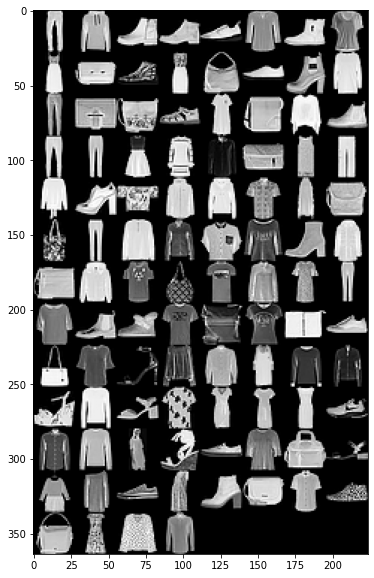

In [7]:
# 데이터(이미지) 확인해보기
from torchvision import utils

dataiter       = iter(train_loader)   # iter함수로 iteration 객체 가져오기
images, labels = next(dataiter)   # next함수로 다음 배치 1개 갖고오기

img   = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

In [8]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        # first layer
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),   # convolution
            torch.nn.ReLU(),   # activation function
            torch.nn.MaxPool2d(kernel_size=2, stride=2))   # pooling

        # second layer
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # fully-connected layer 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

        # fully-connected layer 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = out.view(out.size(0), -1)   # fully-connected layer를 위해서 Flatten
        out = self.fc(out) # fully-connected layer 통과
        return out

In [9]:
model = CNN().to(device)   #모델 정의 및 gpu에 할당

In [10]:
criterion = torch.nn.CrossEntropyLoss().to(device)   # loss function 정의
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)   #optimizer 정의, Adam으로 설정

In [11]:
def training_model(model, data, epochs):
  total_batch = len(data)

  for epoch in range(epochs):
    avg_cost = 0

    for X, Y in data:  #data_loader에 배치들이 저장되어 있음. 한 iteration당 한 개의 배치를 꺼내와서 사용
        X = X.to(device)   #이미지
        Y = Y.to(device)   #레이블(해당 이미지가 뜻하는 숫자)

        optimizer.zero_grad()   #지난 iteration에서 계산했던 기울기 초기화
        hypothesis = model(X)   #순전파 과정으로 예측값 도출
        cost = criterion(hypothesis, Y)   #예측값과 실제값을 비교한 loss
        cost.backward()   #역전파, 기울기 계산
        optimizer.step()   #optimizer로 가중치 갱신

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

In [12]:
#모델 학습
training_model(model = model, data = train_loader, epochs = training_epochs)

[Epoch:    1] cost = 0.483380049
[Epoch:    2] cost = 0.317085922
[Epoch:    3] cost = 0.27944839
[Epoch:    4] cost = 0.254546344
[Epoch:    5] cost = 0.235267207
[Epoch:    6] cost = 0.221529037
[Epoch:    7] cost = 0.205415249
[Epoch:    8] cost = 0.193364367
[Epoch:    9] cost = 0.182690665
[Epoch:   10] cost = 0.173539042
[Epoch:   11] cost = 0.166187629
[Epoch:   12] cost = 0.154695079
[Epoch:   13] cost = 0.146550074
[Epoch:   14] cost = 0.139660046
[Epoch:   15] cost = 0.134293318
[Epoch:   16] cost = 0.125832051
[Epoch:   17] cost = 0.118549719
[Epoch:   18] cost = 0.113474645
[Epoch:   19] cost = 0.107573457
[Epoch:   20] cost = 0.105072342


In [13]:
correct = 0

with torch.no_grad():
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.9132


#### 시도 1 : CNN Layer 추가, 스케일 맞추기 위해서 첫 번째 Pooling layer에 stride와 padding 조정

In [14]:
class CNN_1(torch.nn.Module):

    def __init__(self):
        super(CNN_1, self).__init__()

        # first layer
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),   # convolution
            torch.nn.ReLU(),   # activation function
            torch.nn.MaxPool2d(kernel_size=2, stride= 1, padding= 1))   # pooling

        # second layer
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # fully-connected layer 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

        # fully-connected layer 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = self.layer3(out)   # third layer 통과
        out = out.view(out.size(0), -1)   # fully-connected layer를 위해서 Flatten
        out = self.fc(out) # fully-connected layer 통과
        return out

In [15]:
model1 = CNN_1().to(device)

In [16]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)

In [17]:
#모델 학습
training_model(model = model1, data = train_loader, epochs = training_epochs)

[Epoch:    1] cost = 0.514424145
[Epoch:    2] cost = 0.325103968
[Epoch:    3] cost = 0.28209272
[Epoch:    4] cost = 0.254527092
[Epoch:    5] cost = 0.235311389
[Epoch:    6] cost = 0.220426187
[Epoch:    7] cost = 0.206955269
[Epoch:    8] cost = 0.195477456
[Epoch:    9] cost = 0.182725191
[Epoch:   10] cost = 0.172548652
[Epoch:   11] cost = 0.162802294
[Epoch:   12] cost = 0.15515101
[Epoch:   13] cost = 0.145693094
[Epoch:   14] cost = 0.136031628
[Epoch:   15] cost = 0.130290404
[Epoch:   16] cost = 0.122304149
[Epoch:   17] cost = 0.114463359
[Epoch:   18] cost = 0.109232128
[Epoch:   19] cost = 0.105375484
[Epoch:   20] cost = 0.0984506756


In [18]:
correct = 0
with torch.no_grad():
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model1(data)
            
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.9169


#### 시도 2 > CNN layer추가하고 Pooling layer 일부 사용(모델 아키텍쳐는 이후 유지)

In [19]:
class CNN_2(torch.nn.Module):

    def __init__(self):
        super(CNN_2, self).__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),   # convolution
            torch.nn.ReLU(),   # activation function
            torch.nn.MaxPool2d(kernel_size=2, stride= 2))   # pooling

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=1, padding = 1)
            )
  
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.layer6 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.layer7 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # fully-connected layer 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

        # fully-connected layer 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = self.layer3(out)   # third layer 통과
        out = self.layer4(out)  
        out = self.layer5(out)  
        out = self.layer6(out)
        out = self.layer7(out)
        out = out.view(out.size(0), -1)   # fully-connected layer를 위해서 Flatten
        out = self.fc(out) # fully-connected layer 통과
        return out

In [20]:
model2 = CNN_2().to(device)

In [21]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [22]:
training_model(model = model2, data = train_loader, epochs = training_epochs)

[Epoch:    1] cost = 0.562681913
[Epoch:    2] cost = 0.330006421
[Epoch:    3] cost = 0.285622656
[Epoch:    4] cost = 0.25838989
[Epoch:    5] cost = 0.240934566
[Epoch:    6] cost = 0.224614635
[Epoch:    7] cost = 0.212693438
[Epoch:    8] cost = 0.199911073
[Epoch:    9] cost = 0.189811841
[Epoch:   10] cost = 0.17987363
[Epoch:   11] cost = 0.168522984
[Epoch:   12] cost = 0.161008701
[Epoch:   13] cost = 0.15243119
[Epoch:   14] cost = 0.142486095
[Epoch:   15] cost = 0.135642081
[Epoch:   16] cost = 0.127849311
[Epoch:   17] cost = 0.120976828
[Epoch:   18] cost = 0.112624817
[Epoch:   19] cost = 0.10333284
[Epoch:   20] cost = 0.0991656184


In [23]:
correct = 0

with torch.no_grad():
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model2(data)
            
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.9094


#### 시도3 > 선형 레이어 + dropout 추가

In [24]:
class CNN_3(torch.nn.Module):

    def __init__(self):
        super(CNN_3, self).__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),   # convolution
            torch.nn.ReLU(),   # activation function
            torch.nn.MaxPool2d(kernel_size=2, stride= 2))   # pooling

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=1, padding = 1)
            )
  
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.layer6 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.layer7 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = torch.nn.Linear(7 * 7 * 64, 512, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)
        self.layer8 = torch.nn.Sequential(
            self.fc,
            torch.nn.ReLU(),
            torch.nn.Dropout(p = 0.3))
        
        self.fc2 = torch.nn.Linear(512, 128, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        self.layer9 = torch.nn.Sequential(
            self.fc2,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.3))
         
        self.fc3 = torch.nn.Linear(128, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc3.weight)

        # fully-connected layer 한정으로 가중치 초기화
        

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = self.layer3(out)   # third layer 통과
        out = self.layer4(out)  
        out = self.layer5(out)  
        out = self.layer6(out)
        out = self.layer7(out)
        out = out.view(out.size(0), -1)
        out = self.layer8(out)
        out = self.layer9(out)   # fully-connected layer를 위해서 Flatten
        out = self.fc3(out) # fully-connected layer 통과
        return out

In [25]:
model3 = CNN_3().to(device)

In [26]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)

In [27]:
training_model(model = model3, data = train_loader, epochs = training_epochs)

[Epoch:    1] cost = 0.641522825
[Epoch:    2] cost = 0.349451303
[Epoch:    3] cost = 0.297838241
[Epoch:    4] cost = 0.268412441
[Epoch:    5] cost = 0.247080073
[Epoch:    6] cost = 0.229441479
[Epoch:    7] cost = 0.213399142
[Epoch:    8] cost = 0.197433546
[Epoch:    9] cost = 0.185419515
[Epoch:   10] cost = 0.175098643
[Epoch:   11] cost = 0.162049577
[Epoch:   12] cost = 0.152318686
[Epoch:   13] cost = 0.142930314
[Epoch:   14] cost = 0.137910157
[Epoch:   15] cost = 0.125292674
[Epoch:   16] cost = 0.119680293
[Epoch:   17] cost = 0.112281002
[Epoch:   18] cost = 0.107440583
[Epoch:   19] cost = 0.102606572
[Epoch:   20] cost = 0.0940416083


In [29]:
correct = 0

with torch.no_grad():
    model3.eval()
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model3(data)
            
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.9182


####시도4 > 시도 3에서 채널수 2배로 조정

In [30]:
class CNN_4(torch.nn.Module):

    def __init__(self):
        super(CNN_4, self).__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),   # convolution
            torch.nn.ReLU(),   # activation function
            torch.nn.MaxPool2d(kernel_size=2, stride= 2))   # pooling

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=1, padding = 1)
            )
  
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.layer6 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.layer7 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = torch.nn.Linear(7 * 7 * 128, 512, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)
        self.layer8 = torch.nn.Sequential(
            self.fc,
            torch.nn.ReLU(),
            torch.nn.Dropout(p = 0.3))
        
        self.fc2 = torch.nn.Linear(512, 128, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        self.layer9 = torch.nn.Sequential(
            self.fc2,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.3))
         
        self.fc3 = torch.nn.Linear(128, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc3.weight)

        # fully-connected layer 한정으로 가중치 초기화
        

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = self.layer3(out)   # third layer 통과
        out = self.layer4(out)  
        out = self.layer5(out)  
        out = self.layer6(out)
        out = self.layer7(out)
        out = out.view(out.size(0), -1)
        out = self.layer8(out)
        out = self.layer9(out)   # fully-connected layer를 위해서 Flatten
        out = self.fc3(out) # fully-connected layer 통과
        return out

In [31]:
model4 = CNN_4().to(device)

In [32]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model4.parameters(), lr=learning_rate)

In [33]:
training_model(model = model4, data = train_loader, epochs = training_epochs)

[Epoch:    1] cost = 0.626716018
[Epoch:    2] cost = 0.33411628
[Epoch:    3] cost = 0.287789494
[Epoch:    4] cost = 0.257979065
[Epoch:    5] cost = 0.237572312
[Epoch:    6] cost = 0.218659282
[Epoch:    7] cost = 0.20365651
[Epoch:    8] cost = 0.194150701
[Epoch:    9] cost = 0.180126965
[Epoch:   10] cost = 0.170722857
[Epoch:   11] cost = 0.158951208
[Epoch:   12] cost = 0.146408603
[Epoch:   13] cost = 0.141795248
[Epoch:   14] cost = 0.133566797
[Epoch:   15] cost = 0.123673663
[Epoch:   16] cost = 0.117784239
[Epoch:   17] cost = 0.110643305
[Epoch:   18] cost = 0.107618868
[Epoch:   19] cost = 0.101225592
[Epoch:   20] cost = 0.0936119035


In [34]:
correct = 0

with torch.no_grad():
    model4.eval()
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model4(data)
            
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.9194


#### 시도 5 > 시도 4에서 풀링방법 조절  
제로패딩이 있는 풀링층은 max 풀링, 제로 패딩이 없는 풀링층은 avg풀링 적용 

In [50]:
class CNN_5(torch.nn.Module):

    def __init__(self):
        super(CNN_5, self).__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),   # convolution
            torch.nn.ReLU(),   # activation function
            torch.nn.AvgPool2d(kernel_size=2, stride= 2))   # pooling

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=1, padding = 1)
            )
  
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.layer6 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.layer7 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2))

        self.fc = torch.nn.Linear(7 * 7 * 128, 512, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)
        self.layer8 = torch.nn.Sequential(
            self.fc,
            torch.nn.ReLU(),
            torch.nn.Dropout(p = 0.3))
        
        self.fc2 = torch.nn.Linear(512, 128, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        self.layer9 = torch.nn.Sequential(
            self.fc2,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.3))
         
        self.fc3 = torch.nn.Linear(128, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc3.weight)

        # fully-connected layer 한정으로 가중치 초기화
        

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = self.layer3(out)   # third layer 통과
        out = self.layer4(out)  
        out = self.layer5(out)  
        out = self.layer6(out)
        out = self.layer7(out)
        out = out.view(out.size(0), -1)
        out = self.layer8(out)
        out = self.layer9(out)   # fully-connected layer를 위해서 Flatten
        out = self.fc3(out) # fully-connected layer 통과
        return out

In [59]:
model5 = CNN_5().to(device)

In [60]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model5.parameters(), lr=learning_rate)

In [61]:
training_model(model = model5, data = train_loader, epochs = 20)

[Epoch:    1] cost = 0.616919577
[Epoch:    2] cost = 0.346937954
[Epoch:    3] cost = 0.293514043
[Epoch:    4] cost = 0.261823058
[Epoch:    5] cost = 0.237452805
[Epoch:    6] cost = 0.220261991
[Epoch:    7] cost = 0.204841316
[Epoch:    8] cost = 0.190320104
[Epoch:    9] cost = 0.176900789
[Epoch:   10] cost = 0.16218254
[Epoch:   11] cost = 0.1518545
[Epoch:   12] cost = 0.142419264
[Epoch:   13] cost = 0.129740506
[Epoch:   14] cost = 0.119010948
[Epoch:   15] cost = 0.110742144
[Epoch:   16] cost = 0.103796773
[Epoch:   17] cost = 0.0996882319
[Epoch:   18] cost = 0.0917849392
[Epoch:   19] cost = 0.0840007737
[Epoch:   20] cost = 0.0781902447


In [62]:
correct = 0

with torch.no_grad():
    model5.eval()
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model5(data)
            
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.922


#### 시도 6 > 시도 5에서 drop out 비율 조정(0.3 > 0.5) epoch 조정 (20 > 15)

In [40]:
class CNN_6(torch.nn.Module):

    def __init__(self):
        super(CNN_6, self).__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),   # convolution
            torch.nn.ReLU(),   # activation function
            torch.nn.AvgPool2d(kernel_size=2, stride= 2))   # pooling

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=1, padding = 1)
            )
  
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.layer6 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.layer7 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2))

        self.fc = torch.nn.Linear(7 * 7 * 128, 512, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)
        self.layer8 = torch.nn.Sequential(
            self.fc,
            torch.nn.ReLU(),
            torch.nn.Dropout(p = 0.5))
        
        self.fc2 = torch.nn.Linear(512, 128, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        self.layer9 = torch.nn.Sequential(
            self.fc2,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5))
         
        self.fc3 = torch.nn.Linear(128, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc3.weight)

        # fully-connected layer 한정으로 가중치 초기화
        

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = self.layer3(out)   # third layer 통과
        out = self.layer4(out)  
        out = self.layer5(out)  
        out = self.layer6(out)
        out = self.layer7(out)
        out = out.view(out.size(0), -1)
        out = self.layer8(out)
        out = self.layer9(out)   # fully-connected layer를 위해서 Flatten
        out = self.fc3(out) # fully-connected layer 통과
        return out

In [46]:
model6 = CNN_6().to(device)

In [47]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model6.parameters(), lr=learning_rate)

In [48]:
training_model(model = model6, data = train_loader, epochs = 15)

[Epoch:    1] cost = 0.712145329
[Epoch:    2] cost = 0.383990586
[Epoch:    3] cost = 0.324878603
[Epoch:    4] cost = 0.290163219
[Epoch:    5] cost = 0.26708886
[Epoch:    6] cost = 0.248682216
[Epoch:    7] cost = 0.231913015
[Epoch:    8] cost = 0.218223095
[Epoch:    9] cost = 0.205709293
[Epoch:   10] cost = 0.194186136
[Epoch:   11] cost = 0.183522224
[Epoch:   12] cost = 0.174980387
[Epoch:   13] cost = 0.163358256
[Epoch:   14] cost = 0.161033571
[Epoch:   15] cost = 0.150271326


In [63]:
correct = 0

with torch.no_grad():
    model6.eval()
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model6(data)
            
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.9274


#### 앙상블 (시도 3~6)

In [68]:
correct = 0

with torch.no_grad():
    model3.eval()
    model4.eval()
    model5.eval()
    model6.eval()
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output0 = model3(data)
            output1 = model4(data)
            output2 = model5(data)
            output3 = model6(data)
            
            output = (output0 + output1 + output2 + output3)/4
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.9352


#### 성능 정리  
시도 0 (은아님 CNN 예시구조) >>> 0.9132  
시도 1 (CNN layer 추가) >>> 0.9169  
시도 2 (CNN layer 추가 + 풀링 층 일부만 사용) >>> 0.9094  
시도 3 (완전 연결층 뒤에 선형층 추가 + drop out 0.3) >>> 0.9182  
시도 4 (시도 3에서 채널 2배) >>> 0.9194  
시도 5 (평균값 풀링, 최대값 풀링 혼용) >>> 0.922  
시도 6 (drop out 0.3 > 0.5, epoch 20 > 15) >>> 0.9274  
앙상블 (시도 3 ~ 시도 6) >>> 0.9352


3가지 시도만 하려 했지만.. 성능이 계속 개선돼서 더 해보았다. 개별 모델에서의 최고 성능은 0.927정도였고 성능이 괜찮은 모델들을 앙상블해 결과를 내본 결과 0.9352의 성능을 보였다. 모델 아키텍쳐를 바꿔가며 성능을 비교했기 때문에 학습률, 옵티마이저, 에포크는 거의 고정시켰다. 이 것들까지 조정하면 더 개선될 여지가 있어보인다.  
  
**모델 아키텍쳐** - AlexNet 구조를 참조해서 만들었고 특이점은 Max pooling과 Avg pooling을 혼용해서 사용하였다. 혼용해서 사용한 이유는 padding이 있는 pooling층의 경우 평균을 해버리면 정보의 손실이 있기 때문에 padding이 있는 풀링층은 Max pooling을 사용했고 padding이 없는 풀링층은 Avg pooling을 사용하였다. Fashion Mnist는 최대값으로 축소를 하는 것보다 평균으로 축소하는 것이 더 바람직해 보인다.  
  
검증 데이터를 따로 두지 않고 학습을 진행해서 학습데이터가 과적합 되어있는지 아닌지를 판단할 수가 없어서 애를 먹었다. 에포크를 바꿔가며 적절한 에포크를 찾았다. **이번 주차에서도 epoch, dropout과 같은 방법이 모델 성능에 중요한 영향을 미쳤다.**  

그렇지만 얼마나 많은 레이어를 쌓아야하는지는 잘 모르겠다..레이어가 깊어질수록 더 자세한 정보를 포착할수는 있지만 그 정도를 잘 모르겠다. > 경험적 + 논문들로 알아야 할 것 같다. 